In [ ]:
# !pip install datasets --upgrade
# !pip install transformers
# !pip install torchvision torch

In [2]:
import os
import json
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/home/ahmedcr7/miniconda3/envs/SafeBlur-AI/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
# os.chdir("../")

In [5]:
with open("./data/train.json", 'r') as f:
  data = json.load(f)

data[0]

{'type': 'chair',
 'color': 'gold',
 'prompt': 'Professional product photography of a industrial gold chair, made of plywood, modular shape, featuring mesh back, conference in mind, luxury price range. Pure white background, studio lighting, commercial product photography, 8k, ultra detailed, centered composition, professional furniture catalog style',
 'img_path': '/home/ahmedcr7/Programming/Graduation_Project/ImageTextSearchEngine/data/train_images/image_0.jpg'}

In [6]:
colors = []
for raw in data:
    if raw['color'] not in colors:
        colors.append(raw['color'])
colors

['gold',
 'red',
 'oak',
 'pink',
 'ivory',
 'black',
 'brass',
 'brown',
 'beige',
 'gray',
 'blue',
 'copper',
 'silver',
 'green',
 'titanium',
 'mauve',
 'bronze',
 'azure',
 'ochre',
 'yellow',
 'cream',
 'sage',
 'teal',
 'purple',
 'onyx',
 'coral',
 'plum',
 'orange',
 'white',
 'graphite',
 'charcoal',
 'burgundy',
 'marble',
 'natural wood',
 'chrome',
 'navy',
 'concrete',
 'pearl',
 'olive',
 'slate',
 'ruby',
 'emerald',
 'crimson',
 'walnut',
 'sapphire',
 'ash',
 'amber',
 'taupe',
 'blush',
 'steel',
 'terra',
 'cognac',
 'obsidian',
 'crystal',
 'mint']

In [6]:
import torch
from PIL import Image
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel

# load the feature extraction models
model = CLIPModel.from_pretrained("../../Python/Feature_Extraction_Models/clip_model/")
processor = CLIPProcessor.from_pretrained("../../Python/Feature_Extraction_Models/clip_model/")

2025-05-20 05:58:10.792727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747709891.377642   11608 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747709891.442281   11608 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 05:58:12.469325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be t

In [ ]:
# # embedding for all images

# embedding_vector = []

# for elm in Data:
#   img = Image.open(elm["img_path"])

#   # Preprocess image for CLIP
#   input = processor(images=img, return_tensors="pt")["pixel_values"]

#   with torch.no_grad():
#     image_features = model.get_image_features(input)

#   # convert the features to unit vector
#   # cosine similarity only care about the angle between the feature vectors
#   image_features = F.normalize(image_features, dim=-1)
#   embedding_vector.append(image_features.cpu().numpy())

# embedding_vector[0]

In [ ]:
# np.save("/content/drive/MyDrive/ii/embedding_vectors.npy", embedding_vector)

In [7]:
embedding_vector = np.load("embedding_vectors.npy")
embedding_vector.shape

(5000, 1, 512)

In [8]:
embedding_vector = embedding_vector.squeeze()
embedding_vector.shape

(5000, 512)

In [ ]:
# !pip install qdrant-client
# !pip install fastapi uvicorn

In [9]:
# from google.colab import userdata

# QDRANT_HOST = userdata.get('QDRANT_HOST')
# QDRANT_API_KEY = userdata.get('QDRANT_API_KEY')

from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# Access variables
QDRANT_HOST = os.getenv("QDRANT_HOST")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

In [10]:
from qdrant_client import models, QdrantClient

client = QdrantClient(
    url=QDRANT_HOST,
    api_key=QDRANT_API_KEY,
    timeout=60.0
)

In [18]:
collection_name = "images"
client.recreate_collection(
    collection_name = collection_name,
    vectors_config=models.VectorParams(
        size=512,
        distance=models.Distance.COSINE
    ),
)

/tmp/ipykernel_21130/2512725513.py:2: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [ ]:
from qdrant_client.models import PointStruct

batch_size = 50

# save data in Qdrant database
for step in range(0, len(data), batch_size):
  points = []
  batch = data[step:step+batch_size]

  for idx, raw in enumerate(batch):
    points.append(PointStruct(
        id = idx + step,
        vector = embedding_vector[idx + step],
        payload = {"color": raw['color']}
    ))

  client.upsert(collection_name=collection_name, points=points)

In [ ]:
from qdrant_client.http.models import PayloadSchemaType

# add filter by color option
client.create_payload_index(
    collection_name=collection_name,
    field_name="color",
    field_schema=PayloadSchemaType.KEYWORD
)

UpdateResult(operation_id=11, status=<UpdateStatus.COMPLETED: 'completed'>)

In [15]:
with open("./data/test.json", 'r') as f:
    test_data = json.load(f)

test_example = test_data[0]
test_example

{'type': 'chair',
 'color': 'orange',
 'prompt': 'Professional product photography of a armchair orange chair, made of wood, featuring plain seat, office in mind. Pure white background, studio lighting, commercial product photography, 8k, ultra detailed, centered composition, professional furniture catalog style',
 'img_path': '/home/ahmedcr7/Programming/Graduation_Project/ImageTextSearchEngine/data/test_images/image_7000.jpg'}

In [30]:
img = Image.open(test_example["img_path"])

input = processor(images=img, return_tensors="pt")["pixel_values"]

with torch.no_grad():
  query_image = model.get_image_features(input)

query_image = F.normalize(query_image, dim=-1)
query_image = query_image.cpu().numpy()[0]
query_image

array([ 3.60681070e-03,  4.08905409e-02,  2.97183879e-02, -2.09851339e-02,
       -2.33053714e-02,  4.78760228e-02,  2.91943830e-02,  3.30188647e-02,
       -3.40386201e-03,  7.60901021e-03, -2.06323415e-02,  4.44927290e-02,
       -1.01097729e-02, -2.49050204e-02,  1.78225115e-02,  2.58946232e-02,
        2.74545439e-02,  1.19198123e-02, -9.68669634e-03, -1.48235844e-03,
        3.85272615e-02, -1.95868146e-02,  1.76066142e-02,  4.00769711e-02,
        1.80341527e-02,  4.15289290e-02,  2.52515581e-02, -1.15033509e-02,
       -1.09102605e-02,  9.70238540e-03,  2.19240673e-02,  1.59190949e-02,
       -8.75500403e-03,  4.46057878e-03, -1.66795626e-02, -4.76955175e-02,
       -3.70854549e-02,  1.00755487e-02,  5.57235405e-02,  9.79740918e-02,
       -2.85808742e-02,  2.97518051e-03, -7.75924791e-03, -9.86444671e-03,
        4.04870249e-02, -2.13360474e-01, -2.21807547e-02,  1.16016846e-02,
       -1.57648511e-02,  5.74489161e-02,  3.67362704e-03, -3.53509635e-02,
        5.32677323e-02, -

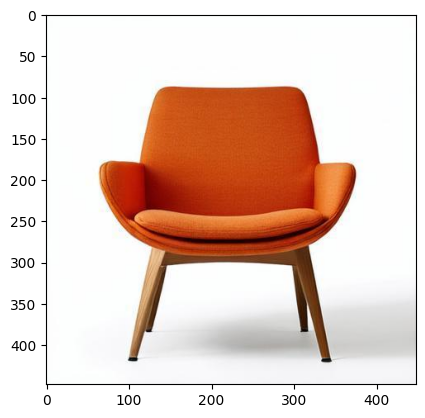

In [31]:
plt.imshow(img)
plt.show()

# Search

In [32]:
search_result = client.search(
    collection_name="images",
    query_vector=query_image,
    limit=10
)

/tmp/ipykernel_11608/4161197864.py:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


Score: 0.9823644
Color: orange


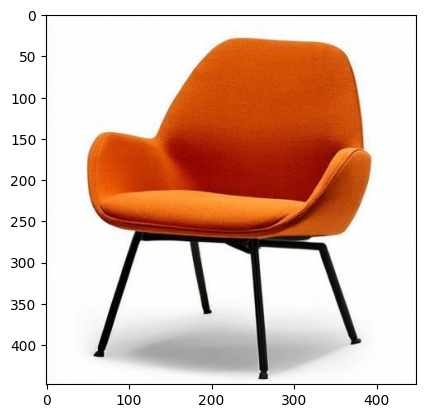

Score: 0.9727013
Color: orange


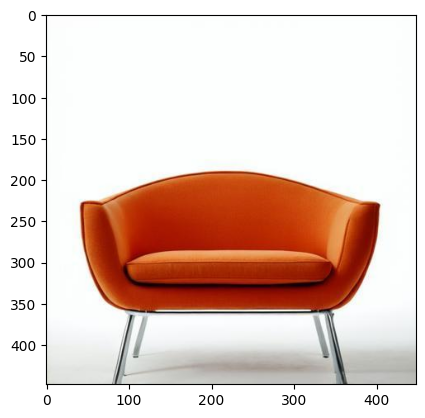

Score: 0.97210526
Color: orange


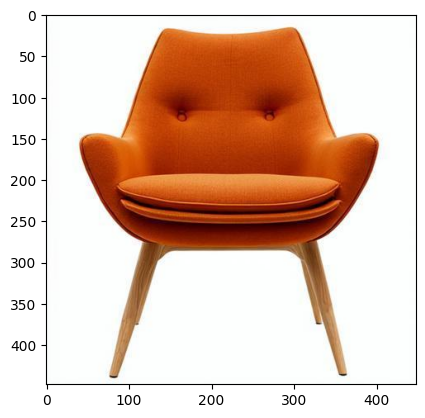

Score: 0.9712285
Color: amber


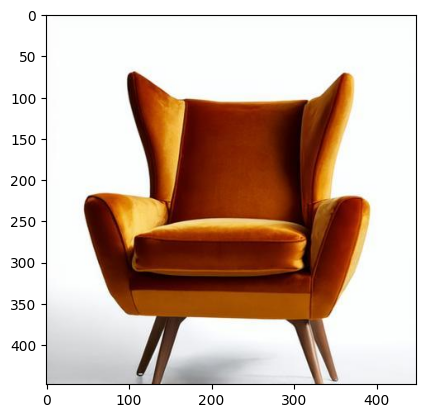

Score: 0.96732956
Color: orange


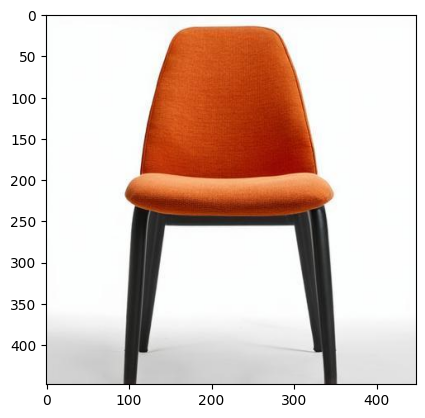

Score: 0.96610856
Color: orange


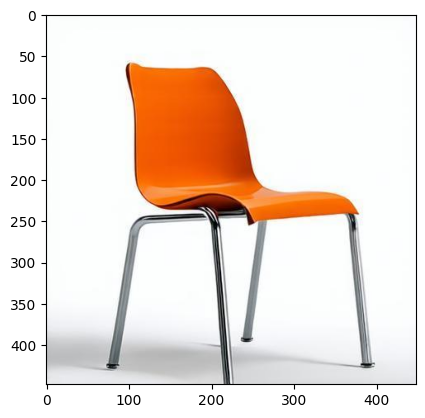

Score: 0.9650792
Color: ash


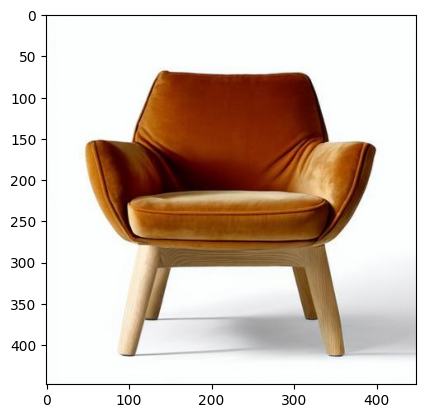

Score: 0.9643801
Color: orange


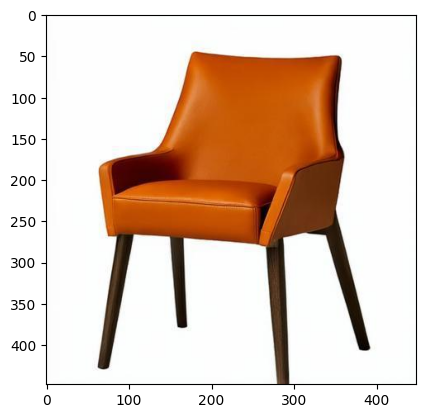

Score: 0.963479
Color: orange


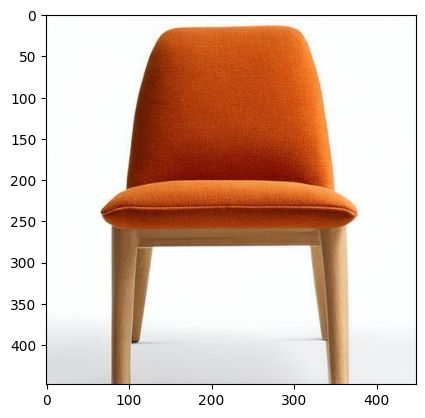

Score: 0.9613558
Color: orange


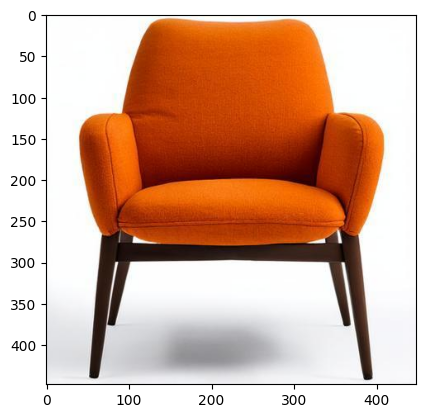

In [33]:
for hit in search_result:
  print("Score:", hit.score)
  print("Color:", hit.payload["color"])
  curr_img = Image.open(data[hit.id]["img_path"])
  plt.imshow(curr_img)
  plt.show()

# Color filter Search

In [34]:
from qdrant_client.http import models

search_result = client.search(
    collection_name="images",
    query_vector=query_image,
    limit=10,
    query_filter=models.Filter(
        must=[
            models.FieldCondition(
                key="color",
                match=models.MatchValue(value="gray")
            )
        ]
    )
)

/tmp/ipykernel_11608/1088033663.py:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


Score: 0.93691975
Color: gray


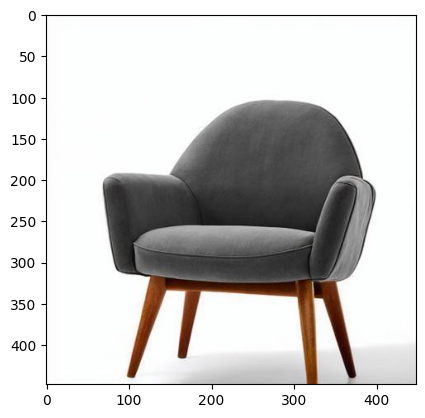

Score: 0.9329852
Color: gray


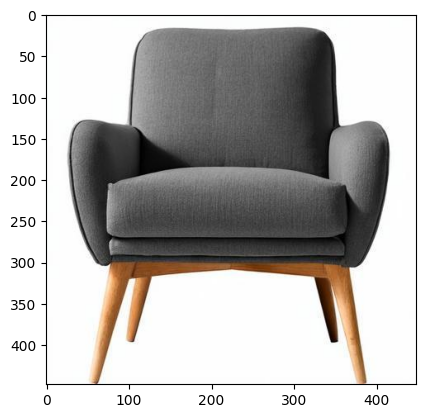

Score: 0.9310638
Color: gray


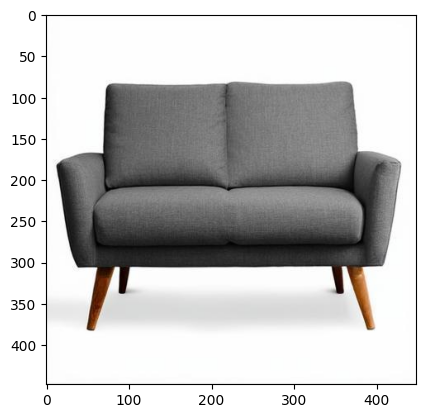

Score: 0.93077946
Color: gray


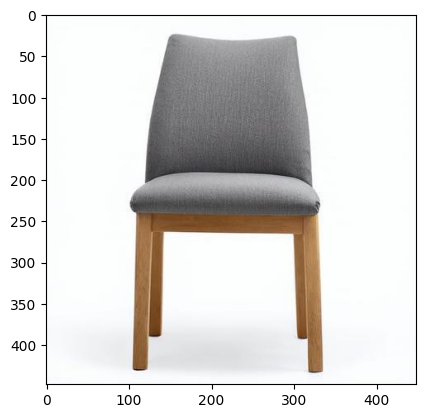

Score: 0.9245292
Color: gray


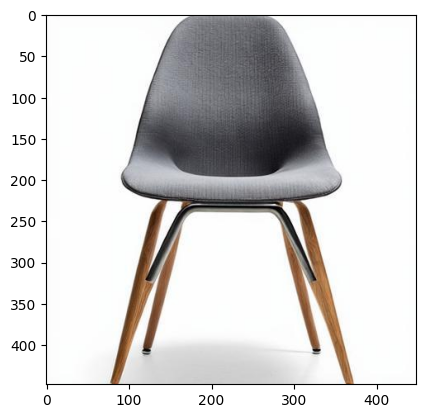

Score: 0.9242967
Color: gray


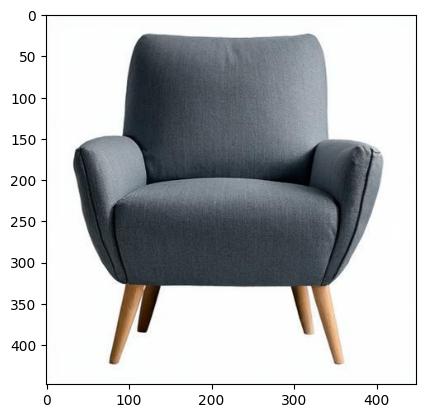

Score: 0.9167251
Color: gray


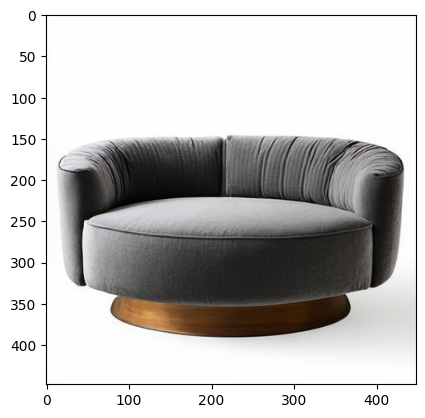

Score: 0.91609466
Color: gray


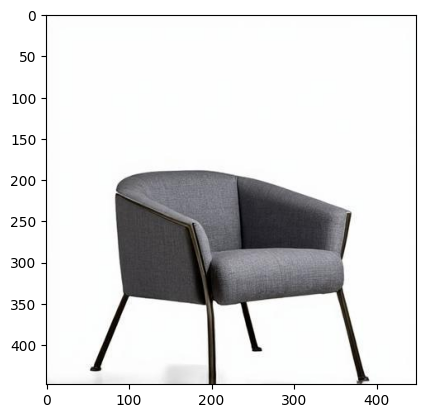

Score: 0.91507095
Color: gray


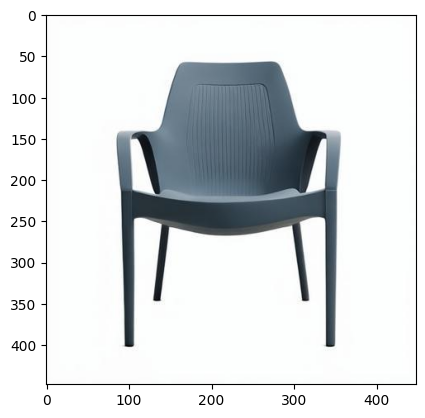

Score: 0.9141021
Color: gray


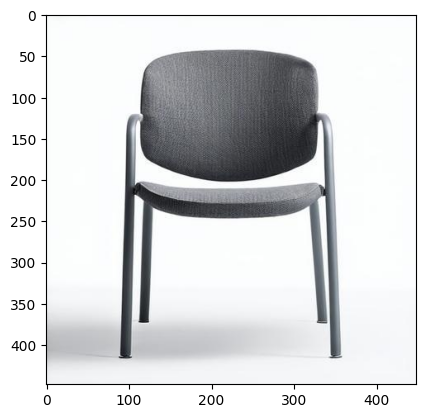

In [35]:
for hit in search_result:
  print("Score:", hit.score)
  print("Color:", hit.payload["color"])
  curr_img = Image.open(data[hit.id]["img_path"])
  plt.imshow(curr_img)
  plt.show()